## Visualizing the geometry of "factual"representation

### Preprocessing

#### Prepare the data

In [1]:
import numpy as np

# Replace the file path with the actual path to your .npy file
layer_wise = np.load('features/llama_chat_xsum_layer_wise.npy')
head_wise = np.load('features/llama_chat_xsum_head_wise.npy')
labels = np.load('features/llama_chat_xsum_labels.npy')

In [2]:
print("Layer wise shape:",layer_wise.shape)
print("Head wise shape:",head_wise.shape)

Layer wise shape: (1700, 33, 4096)
Head wise shape: (1700, 32, 32, 128)


In [3]:
print(layer_wise[0])

[[ 1.0192871e-02  9.7656250e-03 -5.2795410e-03 ...  2.9296875e-03
   4.0817261e-04 -5.0964355e-03]
 [-2.0647168e-02  2.2546530e-02  1.6834918e-02 ... -2.6658395e-02
   1.5001459e-02  1.2572596e-02]
 [-3.3422463e-02  4.1429583e-02  2.8596230e-02 ... -5.1853895e-02
   5.6901224e-02  1.8840881e-02]
 ...
 [-9.5405865e-01  1.1373022e+00 -8.8511300e-01 ... -7.0565665e-01
   8.4431320e-02 -1.3553220e-01]
 [-6.1109203e-01  8.5946649e-01 -9.7498435e-01 ... -3.4153113e-01
  -9.3509868e-02  1.5408240e-02]
 [-2.1220441e+00  1.0302895e+00 -8.3058083e-01 ...  3.0674499e-01
  -1.1795624e+00  1.0600437e+00]]


In [4]:
print(labels[:20])

[1.         5.         5.         5.         5.         5.
 4.66666667 5.         5.         5.         5.         5.
 5.         3.         5.         5.         2.33333333 2.
 5.         5.        ]


#### Update to binary labels

In [5]:
threshold = 3.5
labels = (labels >= threshold).astype(int)

In [6]:
# Check updated labels
print("Updated binary labels:", labels)

# Check label distribution
unique, counts = np.unique(labels, return_counts=True)
print("Binary label distribution:", dict(zip(unique, counts)))

Updated binary labels: [0 1 1 ... 1 1 1]
Binary label distribution: {np.int64(0): np.int64(156), np.int64(1): np.int64(1544)}


In [7]:
assert head_wise.shape[0] == labels.shape[0]
assert layer_wise.shape[0] == labels.shape[0]

# Example: Selecting only factual (label=1) and non-factual (label=0) samples
factual_indices = labels == 1
non_factual_indices = labels == 0

head_wise_factual = head_wise[factual_indices]
layer_wise_factual = layer_wise[factual_indices]

head_wise_non_factual = head_wise[non_factual_indices]
layer_wise_non_factual = layer_wise[non_factual_indices]

#### Shape of the activations

In [8]:
print("Head-wise factual activations shape:", head_wise_factual.shape)
print("Layer-wise factual activations shape:", layer_wise_factual.shape)
print("Head-wise non-factual activations shape:", head_wise_non_factual.shape)
print("Layer-wise non-factual activations shape:", layer_wise_non_factual.shape)

Head-wise factual activations shape: (1544, 32, 32, 128)
Layer-wise factual activations shape: (1544, 33, 4096)
Head-wise non-factual activations shape: (156, 32, 32, 128)
Layer-wise non-factual activations shape: (156, 33, 4096)


In [9]:
print("Label counts:", np.unique(labels, return_counts=True))

Label counts: (array([0, 1]), array([ 156, 1544]))


#### Quantify the data: seems like it has imbalance

In [10]:
from collections import Counter
print("Class distribution:", Counter(labels))

Class distribution: Counter({np.int64(1): 1544, np.int64(0): 156})


## Calculating mean and difference for each layer

In [11]:
import numpy as np

layer_wise_fmean = np.mean(layer_wise_factual, axis = 0)
layer_wise_nfmean =np.mean(layer_wise_non_factual, axis = 0)

difference = layer_wise_fmean - layer_wise_nfmean
print(difference.shape)

import numpy as np

# Compute the L2 norm (magnitude) for each layer
layerwise_magnitude = np.linalg.norm(difference, axis=1)  # Shape: (num_layers,)

# Find the index of the layer with the largest difference
most_influential_layer = np.argmax(layerwise_magnitude)
print(f"The most influential layer is layer {most_influential_layer} with a magnitude of {layerwise_magnitude[most_influential_layer]}")



(33, 4096)
The most influential layer is layer 32 with a magnitude of 3.4669477939605713


In [12]:
# Sort the magnitudes in descending order and get the indices of the top 10 layers
top_10_layers_indices = np.argsort(layerwise_magnitude)[::-1][:10]  # Sort in descending order

# Print the top 10 layers with their magnitudes
print("Top 10 Layers with Highest Magnitude of Difference:")
for i in top_10_layers_indices:
    print(f"Layer {i}: Magnitude = {layerwise_magnitude[i]}")


Top 10 Layers with Highest Magnitude of Difference:
Layer 32: Magnitude = 3.4669477939605713
Layer 31: Magnitude = 2.6122024059295654
Layer 30: Magnitude = 2.060713291168213
Layer 29: Magnitude = 1.8459630012512207
Layer 28: Magnitude = 1.6565192937850952
Layer 27: Magnitude = 1.5646260976791382
Layer 26: Magnitude = 1.4332550764083862
Layer 25: Magnitude = 1.3242067098617554
Layer 24: Magnitude = 1.2126593589782715
Layer 23: Magnitude = 1.157791256904602


### Plotting influence of layers in  activation

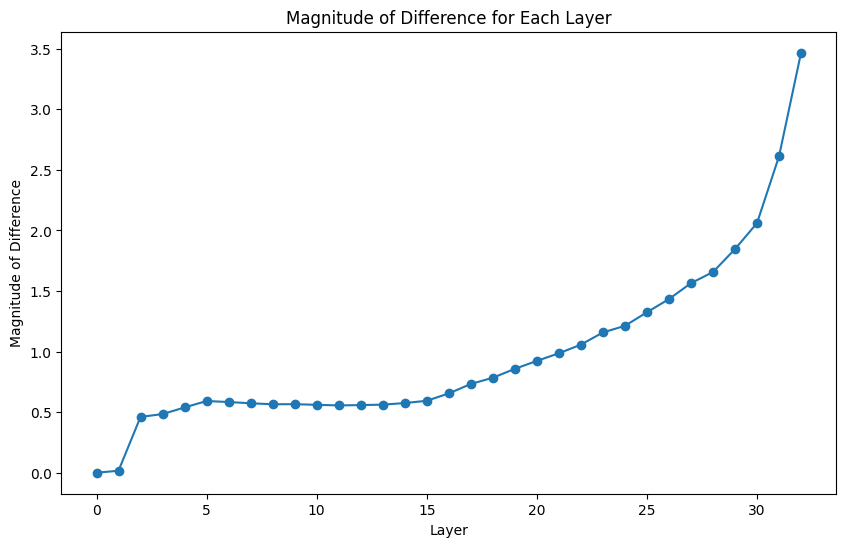

In [13]:
import matplotlib.pyplot as plt

# Plot the layerwise magnitudes
plt.figure(figsize=(10, 6))
plt.plot(layerwise_magnitude, marker='o')
plt.xlabel("Layer")
plt.ylabel("Magnitude of Difference")
plt.title("Magnitude of Difference for Each Layer")
plt.show()


## Calculate the mean and difference for all heads in each layer

In [14]:
import numpy as np

# Compute mean activations per head
mean_factual = np.mean((head_wise_factual), axis=(0, 3))  # Shape: (32, 32)
mean_non_factual = np.mean((head_wise_non_factual), axis=(0, 3))  # Shape: (32, 32)


# Compute the absolute mean magnitude difference per head
mean_magnitude_diff = (mean_factual - mean_non_factual)  # Shape: (32, 32) -> (layers, heads)

print(mean_magnitude_diff.shape)

(32, 32)


## Sort the heads based on difference

In [26]:
# Get sorted head indices for each layer (sorting within each row)
sorted_heads = np.argsort(mean_magnitude_diff, axis=1)  # Sorting in descending order
sorted_mean_magnitude_diff = np.take_along_axis(mean_magnitude_diff, sorted_heads, axis=1)  # Shape: (32, 32)


In [29]:
# Assuming `mean_magnitude_diff` is your (32, 32) array of magnitude differences

top_k = 30  # Number of top heads
top_k_layers_heads = []  # To store layer, head indices
top_k_magnitudes = []  # To store the corresponding maximum magnitudes

# Iterate over each layer and each head to find the max magnitude difference
for layer in range(-mean_magnitude_diff.shape[0]):
    for head in range(mean_magnitude_diff.shape[1]):
        magnitude = mean_magnitude_diff[layer, head]  # Get the magnitude for each layer-head pair
        top_k_layers_heads.append((layer, head))
        top_k_magnitudes.append(magnitude)

# Sort the heads based on the magnitude in descending order
sorted_indices = np.argsort(top_k_magnitudes)[::-1][:top_k]

# Print the top k heads with their layers and the maximum magnitude
print("Top K Heads and Magnitudes (Layer, Head, Magnitude):")
for i in sorted_indices:
    layer, head = top_k_layers_heads[i]
    magnitude = top_k_magnitudes[i]
    print(f"Layer {layer}, Head {head}, Magnitude {magnitude:.4f}")


Top K Heads and Magnitudes (Layer, Head, Magnitude):


## Plot heatmap where y axis is 32 layers and x axis is sorted heads

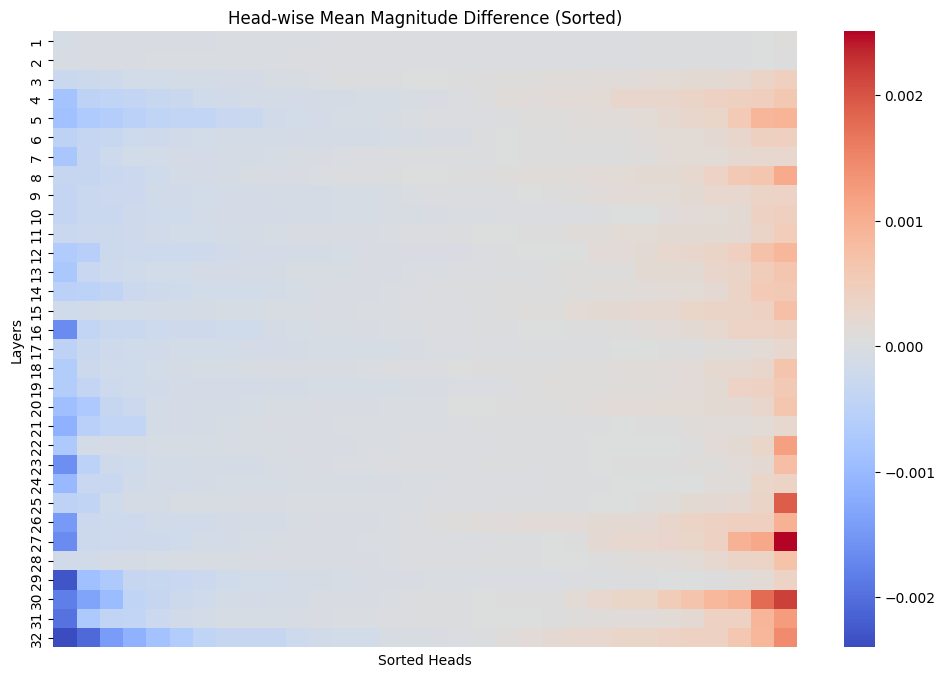

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(sorted_mean_magnitude_diff, cmap="coolwarm", xticklabels=False, yticklabels=np.arange(1, 33))
plt.xlabel("Sorted Heads")
plt.ylabel("Layers")
plt.title("Head-wise Mean Magnitude Difference (Sorted)")
plt.show()

## Train a linear classifier using activations from only those heads and layers with hugh magnitude difference

### Select most important heads & layers

In [20]:
import numpy as np

# Assume `mean_differences` is (num_layers, num_heads) from your analysis
num_layers, num_heads = mean_magnitude_diff.shape

print("Shape of mean_magnitude_diff:", mean_magnitude_diff.shape)  
# Should print: (32, 32)

top_k = 20  # Adjust based on how many heads you want to use

flattened = mean_magnitude_diff.flatten()
sorted_indices = np.argsort(flattened)[::-1][:top_k]  # Get top_k indices

print("Max selected index:", max(sorted_indices))  # Should be ≤ 1023
print("Total possible indices:", num_layers * num_heads)  # Should be 1024



Shape of mean_magnitude_diff: (32, 32)
Max selected index: 1009
Total possible indices: 1024


In [21]:
selected_layers_heads = []
for idx in sorted_indices:
    layer, head = divmod(idx, num_heads)
    if layer >= num_layers:
        print(f"ERROR: Flattened index {idx} maps to invalid layer {layer}")
    selected_layers_heads.append((layer, head))

print("Selected (layer, head) pairs:", selected_layers_heads)


Selected (layer, head) pairs: [(np.int64(26), np.int64(28)), (np.int64(29), np.int64(9)), (np.int64(24), np.int64(3)), (np.int64(29), np.int64(5)), (np.int64(31), np.int64(17)), (np.int64(30), np.int64(18)), (np.int64(21), np.int64(28)), (np.int64(26), np.int64(30)), (np.int64(7), np.int64(6)), (np.int64(29), np.int64(19)), (np.int64(25), np.int64(7)), (np.int64(26), np.int64(23)), (np.int64(4), np.int64(4)), (np.int64(4), np.int64(12)), (np.int64(30), np.int64(9)), (np.int64(31), np.int64(16)), (np.int64(11), np.int64(9)), (np.int64(29), np.int64(21)), (np.int64(22), np.int64(10)), (np.int64(14), np.int64(18))]


### Extract features for classifier

In [22]:
# Ensure you are indexing correctly
selected_head_indices = []
for layer, head in selected_layers_heads:
    index = layer * num_heads + head  # Flattened index
    selected_head_indices.append(index)

print(f"Selected head indices for classification: {selected_head_indices}")


Selected head indices for classification: [np.int64(860), np.int64(937), np.int64(771), np.int64(933), np.int64(1009), np.int64(978), np.int64(700), np.int64(862), np.int64(230), np.int64(947), np.int64(807), np.int64(855), np.int64(132), np.int64(140), np.int64(969), np.int64(1008), np.int64(361), np.int64(949), np.int64(714), np.int64(466)]


In [23]:
X_selected = []  # Feature matrix
y_labels = labels  # Ensure you have labels (factual = 1, non-factual = 0)

for sample in range(len(head_wise)):
    features = []
    for layer, head in selected_layers_heads:
        activation = head_wise[sample, layer, head, :]
        #print(f"Sample {sample}, Layer {layer}, Head {head}, Activation shape: {activation.shape}")
        features.append(activation)
    concatenated_features = np.concatenate(features)
    print(f"Concatenated features shape for sample {sample}: {concatenated_features.shape}")
    X_selected.append(concatenated_features)  # Flatten and store


X_selected = np.array(X_selected)  # Shape: (num_samples, selected_heads * num_features)


Concatenated features shape for sample 0: (2560,)
Concatenated features shape for sample 1: (2560,)
Concatenated features shape for sample 2: (2560,)
Concatenated features shape for sample 3: (2560,)
Concatenated features shape for sample 4: (2560,)
Concatenated features shape for sample 5: (2560,)
Concatenated features shape for sample 6: (2560,)
Concatenated features shape for sample 7: (2560,)
Concatenated features shape for sample 8: (2560,)
Concatenated features shape for sample 9: (2560,)
Concatenated features shape for sample 10: (2560,)
Concatenated features shape for sample 11: (2560,)
Concatenated features shape for sample 12: (2560,)
Concatenated features shape for sample 13: (2560,)
Concatenated features shape for sample 14: (2560,)
Concatenated features shape for sample 15: (2560,)
Concatenated features shape for sample 16: (2560,)
Concatenated features shape for sample 17: (2560,)
Concatenated features shape for sample 18: (2560,)
Concatenated features shape for sample 19

### Train a linear classifier: logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_labels, test_size=0.20, random_state=42)

# Train classifier
clf = LogisticRegression(random_state= 42, class_balance = "balanced")
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9058823529411765


/home/trina/miniconda3/envs/factual/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


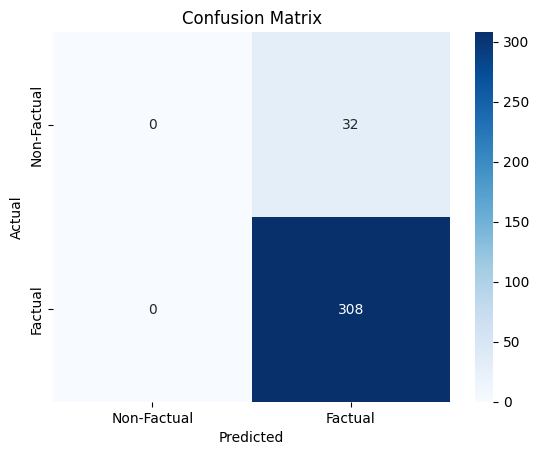

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Factual", "Factual"], yticklabels=["Non-Factual", "Factual"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Non-Factual", "Factual"]))


              precision    recall  f1-score   support

 Non-Factual       0.00      0.00      0.00        32
     Factual       0.91      1.00      0.95       308

    accuracy                           0.91       340
   macro avg       0.45      0.50      0.48       340
weighted avg       0.82      0.91      0.86       340



/home/trina/miniconda3/envs/factual/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/trina/miniconda3/envs/factual/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/trina/miniconda3/envs/factual/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

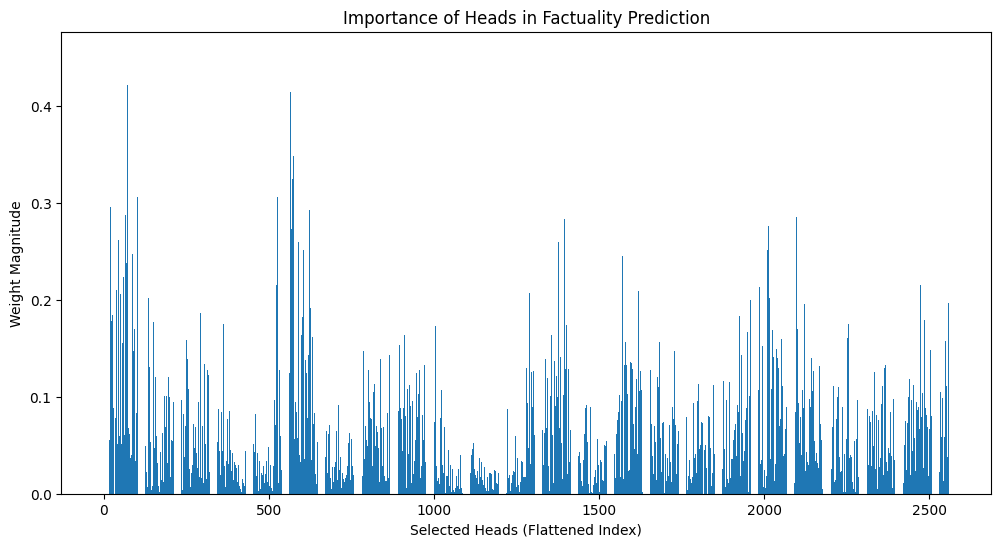

In [33]:
import matplotlib.pyplot as plt

# Get weights from trained classifier
weights = np.abs(clf.coef_[0])  # Absolute value for importance

# Plot importance of each selected head
plt.figure(figsize=(12, 6))
plt.bar(range(len(weights)), weights)
plt.xlabel("Selected Heads (Flattened Index)")
plt.ylabel("Weight Magnitude")
plt.title("Importance of Heads in Factuality Prediction")
plt.show()


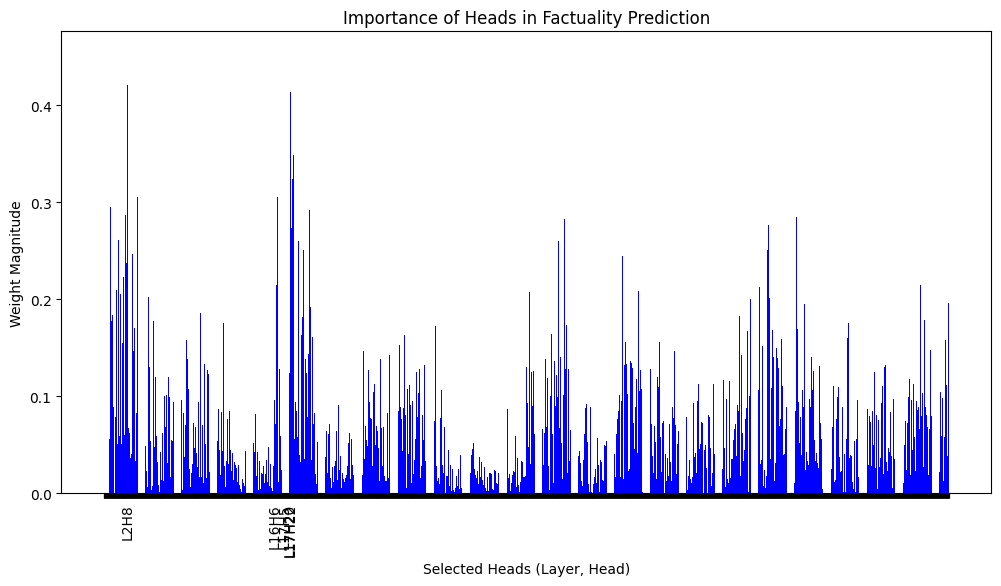

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Get weights from trained classifier
weights = np.abs(clf.coef_[0])  # Absolute value for importance

# Convert flattened indices back to (layer, head)
num_heads = 32  # Fixed number of heads per layer
layer_indices = [idx // num_heads for idx in range(len(weights))]  # Compute layer index
head_indices = [idx % num_heads for idx in range(len(weights))]    # Compute head index

# Create (Layer, Head) labels for x-axis
head_labels = [f"L{layer}H{head}" for layer, head in zip(layer_indices, head_indices)]

# Select **Top N Important Heads** to Label
top_n = 5  # Change this to control how many labels are displayed
top_indices = np.argsort(weights)[-top_n:]  # Get indices of top N heads with highest weight

# Create x-axis labels: Only show for top N important heads
x_labels = [""] * len(weights)  # Start with empty labels
for idx in top_indices:
    x_labels[idx] = head_labels[idx]  # Assign label only for top N

# Plot importance of each selected head with sparse labels
plt.figure(figsize=(12, 6))
plt.bar(range(len(weights)), weights, color="blue")

# Apply selective labels
plt.xticks(ticks=np.arange(len(weights)), labels=x_labels, rotation=90)  # Rotate for readability
plt.xlabel("Selected Heads (Layer, Head)")
plt.ylabel("Weight Magnitude")
plt.title("Importance of Heads in Factuality Prediction")
plt.show()


In [39]:
sorted_indices = np.argsort(weights)[-20:]  # Get indices of top 20 highest-weight heads
print("Top heads according to classifier weights:")
for idx in sorted_indices:
    layer = idx // num_heads
    head = idx % num_heads
    print(f"Layer {layer}, Head {head}, Weight: {weights[idx]}")


Top heads according to classifier weights:
Layer 1, Head 20, Weight: 0.2985961510005332
Layer 0, Head 29, Weight: 0.2997614082137524
Layer 3, Head 6, Weight: 0.30540135330192314
Layer 16, Head 14, Weight: 0.3058141340697695
Layer 5, Head 17, Weight: 0.309633234640624
Layer 16, Head 24, Weight: 0.31850679625144357
Layer 77, Head 10, Weight: 0.32201178504364397
Layer 2, Head 7, Weight: 0.32334131375017655
Layer 17, Head 28, Weight: 0.3239068366909092
Layer 17, Head 31, Weight: 0.34836974715208524
Layer 3, Head 16, Weight: 0.350684406492424
Layer 17, Head 18, Weight: 0.35558506142126955
Layer 3, Head 13, Weight: 0.3556420350007604
Layer 18, Head 6, Weight: 0.3727573589646116
Layer 17, Head 10, Weight: 0.38892137075645233
Layer 17, Head 5, Weight: 0.39518692357205737
Layer 16, Head 6, Weight: 0.4070869854529
Layer 17, Head 22, Weight: 0.4137553198687637
Layer 2, Head 8, Weight: 0.42088265486200266
Layer 17, Head 20, Weight: 0.45352879621667447
